# Feature Selection

## Motivation

We are to explore and apply advanced feature selection techniques to enhance the performance of machine learning models. Feature selection is a crucial step in model development, aimed at identifying the most relevant features while reducing dimensionality. In this notebook, we focused on three prominent feature selection methods: Boruta, Maximum Relevance Minimum Redundancy (MRMR), and Tree-structured Parzen Estimator (TPE) with Optuna integration.

## Methodology:

We are to run different feature selection approaches:

1. Minimum Redundancy Maximum Relevance (SULOV)
2. All relevant (Boruta)
3. Ensemble method i.e the combination of the two feature selection processes.

Then we are to train model with the selected features for each approach and challenge the base model that includes the full set of features.

Finally we are to test an ``ensemble`` approach i.e. we are to take features that appeared in at least one of the 2 feature selection method and use them to train another model.

We  are to use **CV** and validation set for chossing the model with the best performance.

## Conclusions

Interestingtly we found a feature set with Boruta relevant aproach that has the highest score in the validation set.

|           | out_of_fold | validation |
|-----------|------------|------------|
| boruta [68]    | 0.861483   | 0.865860   |
| ensemble [82]  | 0.861489   | 0.865703   |
| base [173]     | 0.861300   | 0.865668   |
| fw [53]        | 0.861526   | 0.865560   |
| original [10]  | 0.863661   | 0.865334   |


In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from featurewiz import featurewiz as fw
from lightgbm import LGBMClassifier as lgbm
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import sys
sys.path.append("../")

# local imports
from src.learner_params import target_column, boruta_learner_params, test_params
from utils.features_lists import all_features_list, base_features
from utils.boruta import BorutaPy

from utils.feature_selection_lists import fw_features, boruta_features, ensemble_features

from utils.functions__training import model_pipeline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_df = pd.read_pickle("../data/train_df.pkl")
validation_df = pd.read_pickle("../data/validation_df.pkl")

## Maximum Relevance Minimum Redundancy (MRMR) Feature Selection

**Maximum Relevance Minimum Redundancy (MRMR)** is a feature selection technique used in machine learning to identify and retain the most informative and non-redundant features for predictive modeling. It aims to strike a balance between the relevance of features to the target variable and the redundancy among selected features.

### How MRMR Works

1. **Relevance Measure**: MRMR begins by calculating a relevance measure for each feature with respect to the target variable. Common relevance measures include mutual information, information gain, or correlation.

2. **Redundancy Measure**: Next, MRMR calculates a redundancy measure between each pair of features. This measure quantifies how similar or redundant two features are in providing information.

3. **Feature Ranking**: MRMR ranks features based on a combination of their relevance and redundancy measures. Features that are highly relevant to the target variable while being minimally redundant with already selected features are given higher ranks.

4. **Sequential Selection**: MRMR performs sequential feature selection, adding features to the selected set one at a time based on their ranking. It iteratively selects the feature that provides the maximum relevance while maintaining minimal redundancy.

### SULOV in featurewiz

**SULOV (Stepwise Univarite Logistic Regression)** is a feature selection method implemented in the "featurewiz" library, which is designed to automate the feature selection process in a stepwise manner using logistic regression. MRMR can be used within SULOV to enhance the feature selection process.

**Steps in SULOV with MRMR**:

1. **Univariate Selection**: SULOV initially applies univariate feature selection to identify relevant features using a specified metric (e.g., chi-squared or F-value).

2. **MRMR Enhancement**: After univariate selection, MRMR is used to further refine the feature set by considering both relevance and redundancy. This step ensures that selected features are not only individually relevant but also collectively non-redundant.

3. **Logistic Regression**: Finally, logistic regression is applied to the selected feature set to build a predictive model. SULOV continues to iterate, adding or removing features based on model performance until a desired level of accuracy or other criteria is met.

### Advantages of MRMR

- **Balanced Selection**: MRMR aims to balance the importance of features to the target variable while avoiding redundancy among selected features.

- **Automation**: When used within libraries like "featurewiz," MRMR can automate the feature selection process, reducing manual effort.

### Limitations

- **Interpretability**: While MRMR can improve model performance, the resulting feature set may be less interpretable compared to a smaller set of manually selected features.

MRMR feature selection, especially when integrated with methods like SULOV in "featurewiz," can be a valuable approach to enhancing the quality of feature sets for machine learning tasks.


############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.9 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Binary_Classification problem ####
    Loaded train data. Shape = (120000, 174)
    Some column names had special characters which were removed...
#### Single_Label Binary_Classification problem ####
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Binary_Classification problem ####
    loading a random sam

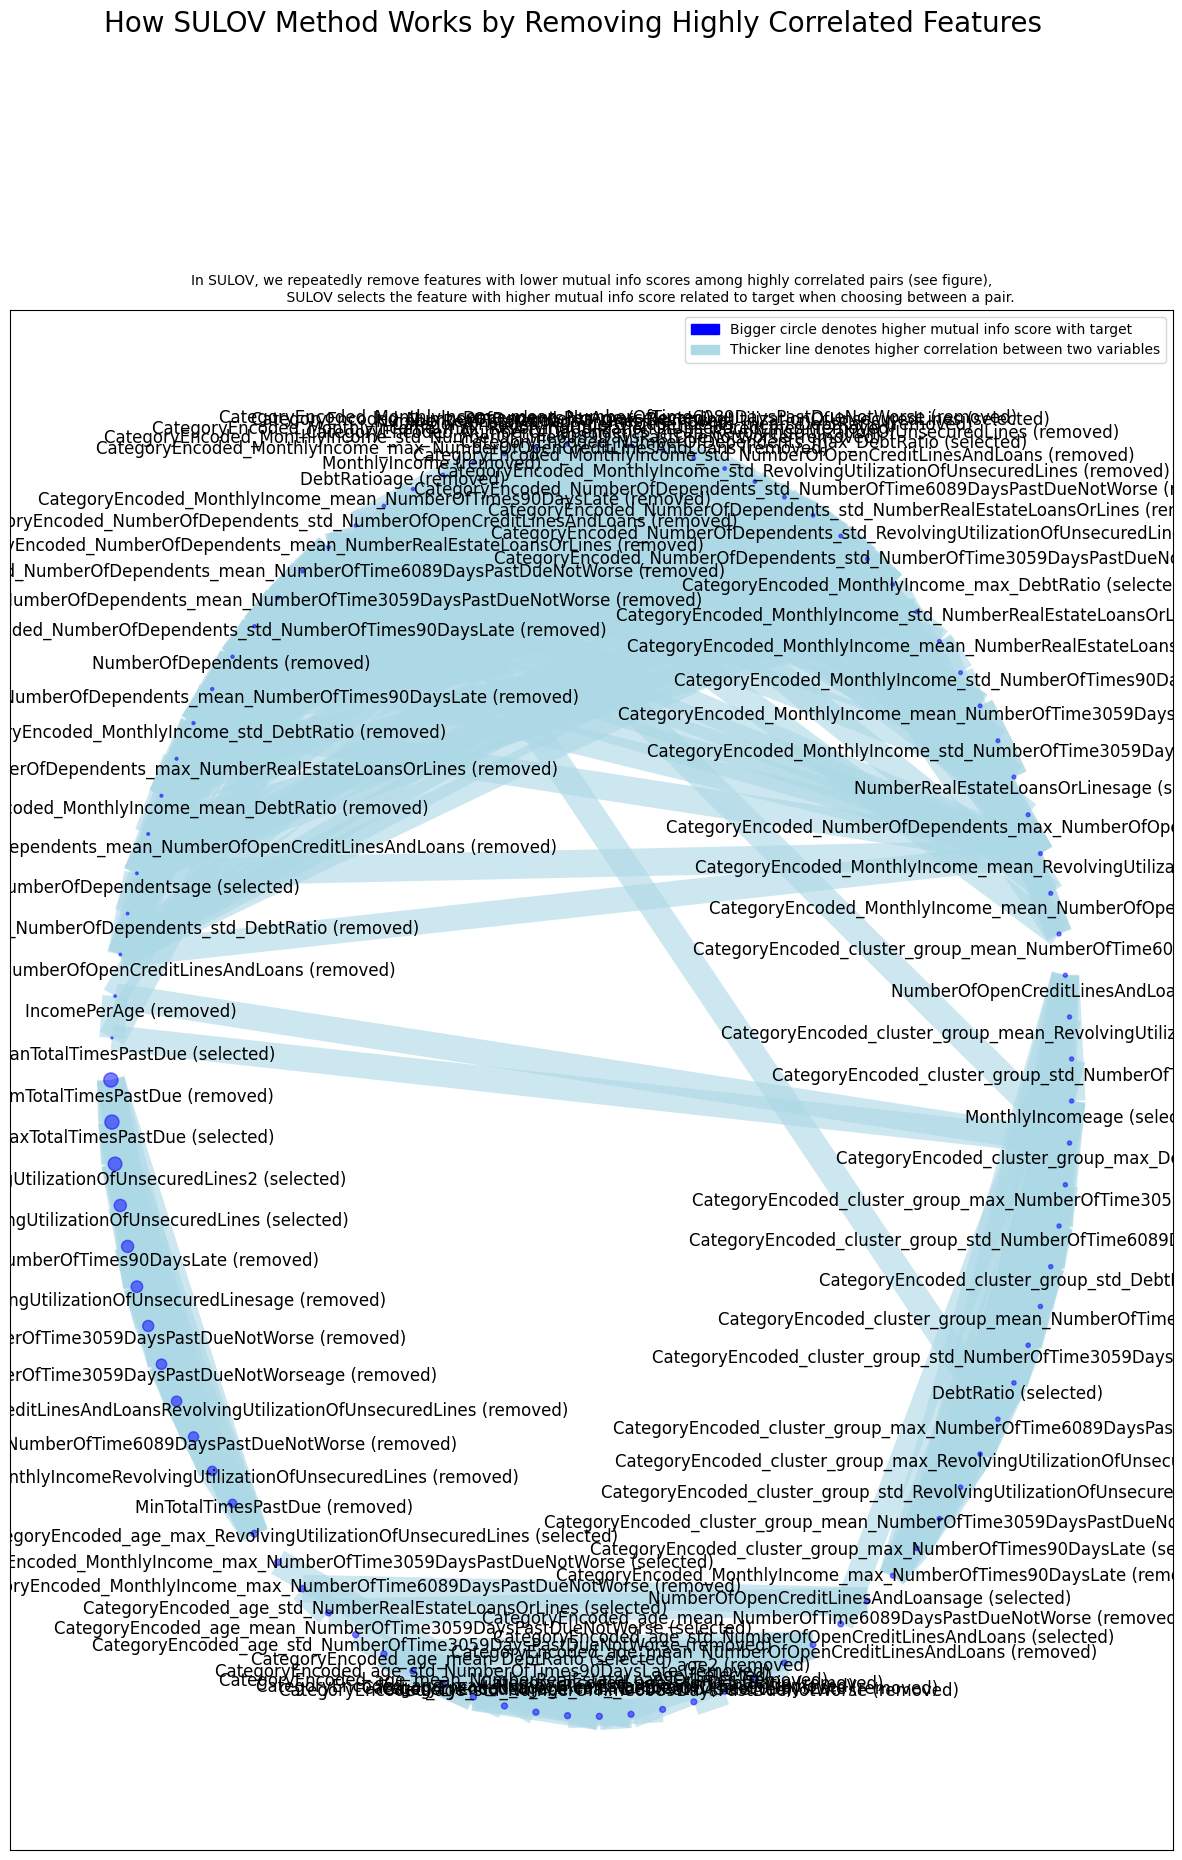

Time taken for SULOV method = 35 seconds
    Adding 0 categorical variables to reduced numeric variables  of 73
Finally 73 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 28 features per iteration...
    XGBoost version using 1.7.6 as tree method: hist
    Number of booster rounds = 20
        Selected: ['prediction_AdaBoostClassifier', 'prediction_RandomForestClassifier', 'RevolvingUtilizationOfUnsecuredLines2', 'SumTotalTimesPastDuePerCreditLineLoan', 'MeanTotalTimesPastDue', 'IncomePerCreditLineLoan', 'PercentageNumberTimes30to59PastDue', 'prediction_MLPClassifier', 'IncomeOverDebtRatio', 'UtilizationOverDebtRatio', 'DebtRatioRevolvingUtiliza

In [3]:
selector = fw(train_df[all_features_list + [target_column]],
              target_column,
              verbose = -1,
              corr_limit=.9
             )

In [5]:
sorted(selector[0])

['CategoryEncoded_MonthlyIncome_max_DebtRatio',
 'CategoryEncoded_MonthlyIncome_max_NumberOfTime30-59DaysPastDueNotWorse',
 'CategoryEncoded_MonthlyIncome_mean_NumberOfOpenCreditLinesAndLoans',
 'CategoryEncoded_MonthlyIncome_mean_RevolvingUtilizationOfUnsecuredLines',
 'CategoryEncoded_MonthlyIncome_std_NumberOfTime30-59DaysPastDueNotWorse',
 'CategoryEncoded_NumberOfDependents_max_NumberOfOpenCreditLinesAndLoans',
 'CategoryEncoded_NumberOfDependents_max_RevolvingUtilizationOfUnsecuredLines',
 'CategoryEncoded_age_max_DebtRatio',
 'CategoryEncoded_age_max_RevolvingUtilizationOfUnsecuredLines',
 'CategoryEncoded_age_mean_DebtRatio',
 'CategoryEncoded_age_mean_NumberOfTime30-59DaysPastDueNotWorse',
 'CategoryEncoded_age_std_NumberOfOpenCreditLinesAndLoans',
 'CategoryEncoded_age_std_NumberRealEstateLoansOrLines',
 'CategoryEncoded_cluster_group_max_NumberOfTimes90DaysLate',
 'CategoryEncoded_cluster_group_std_DebtRatio',
 'CategoryEncoded_cluster_group_std_RevolvingUtilizationOfUnsecur

## Boruta Feature Selection

**Boruta** is a feature selection technique used in machine learning to identify and retain the most relevant features for a predictive model. It is particularly useful when you have a large number of features, and you want to reduce dimensionality while preserving important information.

### How Boruta Works

1. **Duplicate the Dataset**: Boruta starts by duplicating the dataset, creating a shadow dataset with the same features but with randomized values.

2. **Introduce Randomness**: The shadow dataset introduces randomness, making it impossible for the feature selection algorithm to distinguish between relevant and irrelevant features.

3. **Feature Comparison**: Boruta then trains a machine learning model, such as a random forest, on both the original dataset and the shadow dataset. It compares the importance of each feature in the original dataset to that in the shadow dataset.

4. **Feature Ranking**: Features are ranked based on their importance scores. Relevant features tend to have higher scores, while irrelevant features have lower scores.

5. **Thresholding**: Boruta sets a threshold to determine which features to keep. Features with importance scores above the threshold are considered relevant and are retained, while those below the threshold are considered irrelevant and are removed.

### Advantages of Boruta

- **Model Agnostic**: Boruta can be used with various machine learning models, making it versatile and applicable to different tasks.

- **Handles Interaction Effects**: It can capture interaction effects between features, which may be missed by other feature selection methods.

- **Reduced Overfitting**: By eliminating irrelevant features, Boruta helps reduce the risk of overfitting and improves model generalization.

### Limitations

- **Computational Cost**: Running Boruta can be computationally expensive, especially with a large number of features.

- **Randomness**: Boruta relies on randomness in the shadow dataset, which means that results may vary between runs.

- **Threshold Selection**: Choosing an appropriate threshold can be subjective and may require experimentation.

Boruta is a valuable tool for feature selection, especially in cases where you need to sift through a large number of features to improve model performance and interpretability.


In [6]:
%%time
model = lgbm(**boruta_learner_params)
selector = BorutaPy(
    model,
    n_estimators=1000,
    perc=20,
    alpha=0.05,
    max_iter=25,
    random_state=42,
    early_stopping=True,
    n_iter_no_change = 10,
).fit(train_df[all_features_list], train_df[target_column])

CPU times: user 33min 15s, sys: 3min 43s, total: 36min 59s
Wall time: 8min 50s


In [7]:
sorted(np.array(all_features_list)[selector.support_])

['CategoryEncoded_MonthlyIncome_max_DebtRatio',
 'CategoryEncoded_MonthlyIncome_max_RevolvingUtilizationOfUnsecuredLines',
 'CategoryEncoded_age_max_DebtRatio',
 'CategoryEncoded_age_max_NumberOfOpenCreditLinesAndLoans',
 'CategoryEncoded_age_max_NumberRealEstateLoansOrLines',
 'CategoryEncoded_age_mean_NumberOfTime30-59DaysPastDueNotWorse',
 'CategoryEncoded_age_mean_RevolvingUtilizationOfUnsecuredLines',
 'CategoryEncoded_cluster_group_max_DebtRatio',
 'CategoryEncoded_cluster_group_max_NumberOfOpenCreditLinesAndLoans',
 'CategoryEncoded_cluster_group_max_NumberOfTime30-59DaysPastDueNotWorse',
 'CategoryEncoded_cluster_group_max_NumberOfTime60-89DaysPastDueNotWorse',
 'CategoryEncoded_cluster_group_max_NumberOfTimes90DaysLate',
 'CategoryEncoded_cluster_group_max_RevolvingUtilizationOfUnsecuredLines',
 'CategoryEncoded_cluster_group_mean_DebtRatio',
 'CategoryEncoded_cluster_group_mean_NumberOfTime30-59DaysPastDueNotWorse',
 'CategoryEncoded_cluster_group_mean_NumberOfTime60-89DaysPa

### Enesemble feature selection

We are to perform an additional FS process by taking the features that were considered by at least one of the three methods. So we are to remove features that were not importatn for any of the methods.

In [13]:
counter = 0
ls = {}
for feat in all_features_list:
    if feat in fw_features:
        counter+=1
    if feat in boruta_features:
        counter+=1
    ls[feat] = counter
    counter = 0
importance_df = pd.DataFrame(ls.items(), columns = ["feature","n"]).sort_values(by = "n", ascending = False)

In [14]:
importance_df.n.value_counts().sort_index()

n
0    91
1    43
2    39
Name: count, dtype: int64

In [15]:
len(importance_df.query("n >=1").feature.values)

82

In [16]:
sorted(importance_df.query("n >=1").feature.values)

['CategoryEncoded_MonthlyIncome_max_DebtRatio',
 'CategoryEncoded_MonthlyIncome_max_NumberOfTime30-59DaysPastDueNotWorse',
 'CategoryEncoded_MonthlyIncome_max_RevolvingUtilizationOfUnsecuredLines',
 'CategoryEncoded_MonthlyIncome_mean_NumberOfOpenCreditLinesAndLoans',
 'CategoryEncoded_MonthlyIncome_mean_RevolvingUtilizationOfUnsecuredLines',
 'CategoryEncoded_MonthlyIncome_std_NumberOfTime30-59DaysPastDueNotWorse',
 'CategoryEncoded_NumberOfDependents_max_NumberOfOpenCreditLinesAndLoans',
 'CategoryEncoded_NumberOfDependents_max_RevolvingUtilizationOfUnsecuredLines',
 'CategoryEncoded_age_max_DebtRatio',
 'CategoryEncoded_age_max_NumberOfOpenCreditLinesAndLoans',
 'CategoryEncoded_age_max_NumberRealEstateLoansOrLines',
 'CategoryEncoded_age_max_RevolvingUtilizationOfUnsecuredLines',
 'CategoryEncoded_age_mean_DebtRatio',
 'CategoryEncoded_age_mean_NumberOfTime30-59DaysPastDueNotWorse',
 'CategoryEncoded_age_mean_RevolvingUtilizationOfUnsecuredLines',
 'CategoryEncoded_age_std_NumberOf

## Performance comparison

We are to train a model using each of the feature sets, then we are to compare the performance and make the decision about which model we are to take as the final one.

The criteria would be taken using the validation set and the number of features, so we are to consider the model with the best balance between performance and number of features.

In [19]:
original_logs = model_pipeline(train_df = train_df,
                            validation_df = validation_df,
                            params = test_params,
                            target_column = target_column,
                            features = base_features,
                            cv = 3,
                            random_state = 42,
                            apply_shap = False
                          )

2023-10-09T21:15:18 | INFO | Starting pipeline: Generating 3 k-fold training...
2023-10-09T21:15:18 | INFO | Training for fold 1
2023-10-09T21:15:32 | INFO | Training for fold 2
2023-10-09T21:15:46 | INFO | Training for fold 3
2023-10-09T21:16:00 | INFO | CV training finished!
2023-10-09T21:16:00 | INFO | Training the model in the full dataset...
2023-10-09T21:16:16 | INFO | Training process finished!
2023-10-09T21:16:16 | INFO | Calculating metrics...
2023-10-09T21:16:16 | INFO | Full process finished in 0.96 minutes.
2023-10-09T21:16:16 | INFO | Saving the predict function.
2023-10-09T21:16:16 | INFO | Predict function saved.


In [20]:
base_logs = model_pipeline(train_df = train_df,
                            validation_df = validation_df,
                            params = test_params,
                            target_column = target_column,
                            features = all_features_list,
                            cv = 3,
                            random_state = 42,
                            apply_shap = False
                          )

2023-10-09T21:16:16 | INFO | Starting pipeline: Generating 3 k-fold training...
2023-10-09T21:16:16 | INFO | Training for fold 1
2023-10-09T21:16:43 | INFO | Training for fold 2
2023-10-09T21:17:10 | INFO | Training for fold 3
2023-10-09T21:17:38 | INFO | CV training finished!
2023-10-09T21:17:38 | INFO | Training the model in the full dataset...
2023-10-09T21:18:13 | INFO | Training process finished!
2023-10-09T21:18:13 | INFO | Calculating metrics...
2023-10-09T21:18:13 | INFO | Full process finished in 1.95 minutes.
2023-10-09T21:18:13 | INFO | Saving the predict function.
2023-10-09T21:18:13 | INFO | Predict function saved.


In [21]:
boruta_logs = model_pipeline(train_df = train_df,
                            validation_df = validation_df,
                            params = test_params,
                            target_column = target_column,
                            features = boruta_features,
                            cv = 3,
                            random_state = 42,
                            apply_shap = False
                          )

2023-10-09T21:18:13 | INFO | Starting pipeline: Generating 3 k-fold training...
2023-10-09T21:18:13 | INFO | Training for fold 1
2023-10-09T21:18:33 | INFO | Training for fold 2
2023-10-09T21:18:53 | INFO | Training for fold 3
2023-10-09T21:19:13 | INFO | CV training finished!
2023-10-09T21:19:13 | INFO | Training the model in the full dataset...
2023-10-09T21:19:37 | INFO | Training process finished!
2023-10-09T21:19:37 | INFO | Calculating metrics...
2023-10-09T21:19:37 | INFO | Full process finished in 1.40 minutes.
2023-10-09T21:19:37 | INFO | Saving the predict function.
2023-10-09T21:19:37 | INFO | Predict function saved.


In [22]:
fw_logs = model_pipeline(train_df = train_df,
                            validation_df = validation_df,
                            params = test_params,
                            target_column = target_column,
                            features = fw_features,
                            cv = 3,
                            random_state = 42,
                            apply_shap = False
                          )

2023-10-09T21:19:37 | INFO | Starting pipeline: Generating 3 k-fold training...
2023-10-09T21:19:37 | INFO | Training for fold 1
2023-10-09T21:19:55 | INFO | Training for fold 2
2023-10-09T21:20:14 | INFO | Training for fold 3
2023-10-09T21:20:33 | INFO | CV training finished!
2023-10-09T21:20:33 | INFO | Training the model in the full dataset...
2023-10-09T21:20:54 | INFO | Training process finished!
2023-10-09T21:20:54 | INFO | Calculating metrics...
2023-10-09T21:20:54 | INFO | Full process finished in 1.30 minutes.
2023-10-09T21:20:54 | INFO | Saving the predict function.
2023-10-09T21:20:54 | INFO | Predict function saved.


In [23]:
ensemble_logs = model_pipeline(train_df = train_df,
                            validation_df = validation_df,
                            params = test_params,
                            target_column = target_column,
                            features = ensemble_features,
                            cv = 3,
                            random_state = 42,
                            apply_shap = False
                          )

2023-10-09T21:20:55 | INFO | Starting pipeline: Generating 3 k-fold training...
2023-10-09T21:20:55 | INFO | Training for fold 1
2023-10-09T21:21:18 | INFO | Training for fold 2
2023-10-09T21:21:42 | INFO | Training for fold 3
2023-10-09T21:22:05 | INFO | CV training finished!
2023-10-09T21:22:05 | INFO | Training the model in the full dataset...
2023-10-09T21:22:34 | INFO | Training process finished!
2023-10-09T21:22:34 | INFO | Calculating metrics...
2023-10-09T21:22:34 | INFO | Full process finished in 1.65 minutes.
2023-10-09T21:22:34 | INFO | Saving the predict function.
2023-10-09T21:22:34 | INFO | Predict function saved.


### Model evaluation

We are to create a table with the performance and the number of features

In [41]:
model_metrics  ={}
models = [original_logs, base_logs, fw_logs, boruta_logs, ensemble_logs]
names = ["original","base", "fw", "boruta", "ensemble"]
sizes = [len(base_features), len(all_features_list), len(fw_features), len(boruta_features), len(ensemble_features)]

for model, name, size in zip(models, names, sizes):
    model_metrics[f"{name} [{size}]"] = model["metrics"]["roc_auc"]
pd.DataFrame(model_metrics).T.sort_values(by = "validation", ascending = False)

,out_of_fold,validation
base [115],0.862941,0.865959
boruta [46],0.862986,0.865603
ensemble [55],0.862760,0.865526
fw [32],0.862961,0.865385
original [10],0.863661,0.865334


In [24]:
# new
model_metrics  ={}
models = [original_logs, base_logs, fw_logs, boruta_logs, ensemble_logs]
names = ["original","base", "fw", "boruta", "ensemble"]
sizes = [len(base_features), len(all_features_list), len(fw_features), len(boruta_features), len(ensemble_features)]

for model, name, size in zip(models, names, sizes):
    model_metrics[f"{name} [{size}]"] = model["metrics"]["roc_auc"]
pd.DataFrame(model_metrics).T.sort_values(by = "validation", ascending = False)

,out_of_fold,validation
boruta [68],0.861483,0.865860
ensemble [82],0.861489,0.865703
base [173],0.861300,0.865668
fw [53],0.861526,0.865560
original [10],0.863661,0.865334
